# Overview - determining liability in claims
The objective of this project is to utilise the historical data of the claims and develop a liability prediction model which would enable the handlers to swiftly decide on Claims liability at FNOL Stage
***

## Import and prep data

In [ ]:
# Import pandas using the usual alias
import pandas as pd

# Read the dataset from datasets/DataforRFmodel.xlsx in the sheet named 'Data'
claims_raw = pd.read_excel('datasets/DataforRFmodel.xlsx', sheet_name = 'Data')

# Print the data types of claims_raw
print("Data types:")
print(claims_raw.dtypes)

# Print the description of claims_raw
print("\nDescription:")
print(claims_raw.describe)

# Display claims_raw
print("\nDataset:")
print(claims_raw)

In [4]:
# Count the number of missing values in each column of claims_raw
n_missing = claims_raw.isna().sum()
print(f"Number of missing values present in each feature are: \n{n_missing}")

# This code takes a copy of the dataset before we start subsetting
claims = claims_raw.copy(deep = True)

# Drop the missing values from the categorical features of claims
categorical_features = ['Circumstance_code', 'Organization_notified_by', 'Method_of_notification', 'NCD_indicator']
claims = claims.dropna(subset = categorical_features)

# In the Excess feature, fill missing values with 0
claims['Excess'] = claims['Excess'].fillna(0)

# See the updated dataset
claims.info()

Number of missing values present in each feature are: 
Claim_number                 0
Excess                       8
Circumstance_code            9
Organization_notified_by    12
Method_of_notification       7
NCD_indicator                2
Notification_delay           0
Injury                       0
TP_vehicle_damaged           0
Insured_vehicle_damaged      0
Insured_age                  0
Estimated_vehicle_value      0
Liability_group              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3649
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Claim_number              3620 non-null   object 
 1   Excess                    3620 non-null   float64
 2   Circumstance_code         3620 non-null   object 
 3   Organization_notified_by  3620 non-null   object 
 4   Method_of_notification    3620 non-null   object 
 5   NCD_indicator             3620 n

In [6]:
# Count the duplicate claim numbers in the dataset
n_dupes = claims.duplicated().sum()
print(f"There are {n_dupes} duplicates in the Claim_number column.\n")

# Drop the duplicate claims from the dataset
claims_no_dupes = claims.drop_duplicates()

# Drop the entire Claim_number column from claims_no_dupes
claims_no_dupes = claims_no_dupes.drop('Claim_number',axis=1)

# See the updated dataset
claims_no_dupes.info()

There are 10 duplicates in the Claim_number column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3610 entries, 0 to 3649
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Excess                    3610 non-null   float64
 1   Circumstance_code         3610 non-null   object 
 2   Organization_notified_by  3610 non-null   object 
 3   Method_of_notification    3610 non-null   object 
 4   NCD_indicator             3610 non-null   object 
 5   Notification_delay        3610 non-null   int64  
 6   Injury                    3610 non-null   int64  
 7   TP_vehicle_damaged        3610 non-null   int64  
 8   Insured_vehicle_damaged   3610 non-null   int64  
 9   Insured_age               3610 non-null   int64  
 10  Estimated_vehicle_value   3610 non-null   int64  
 11  Liability_group           3610 non-null   object 
dtypes: float64(1), int64(6), object(5)
memory usage: 366.6+ KB


## Develop the model

In [8]:
# Import train_test_split() from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Get the Liability_group column as the response variable
response = claims_no_dupes['Liability_group']

# Get all columns except Liability_group as the features
features = claims_no_dupes.drop('Liability_group',axis=1)

# Get dummies for categorical features
dummies = pd.get_dummies(features,drop_first = True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dummies,response, test_size = 0.3, random_state =16660902)

In [10]:
# Import RandomForestClassifier() from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier object
rf = RandomForestClassifier(random_state = 17551101)

# Fit the random forest model to the training set
rf.fit(X_train,y_train)

# Predict the liabilities from the test features
y_pred = rf.predict(X_test)

# See the prediction counts
pd.Series(y_pred).value_counts()

Fully_Liable    455
Not_Liable      412
Split_Liable    216
dtype: int64

In [12]:
# Import classification_report(), confusion_matrix() and accuracy_score() from sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Get the accuracy score
rf_accuracy_score = accuracy_score(y_test,y_pred)
print(f"Accuracy score: {rf_accuracy_score:.4f}\n")

# Get the confusion matrix
rf_confusion_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix:\n{rf_confusion_matrix}\n")

# Get the classification report
rf_classification_report = classification_report(y_test,y_pred)
print(f"Classification report:\n{rf_classification_report}")

Accuracy score: 0.8024

Confusion matrix:
[[430  43  13]
 [ 20 297  61]
 [  5  72 142]]

Classification report:
              precision    recall  f1-score   support

Fully_Liable       0.95      0.88      0.91       486
  Not_Liable       0.72      0.79      0.75       378
Split_Liable       0.66      0.65      0.65       219

    accuracy                           0.80      1083
   macro avg       0.77      0.77      0.77      1083
weighted avg       0.81      0.80      0.80      1083



In [14]:
# Import KFold() and cross_val_score() from sklearn.model_selection
from sklearn.model_selection import KFold, cross_val_score

# Setup up k-fold cross-validation with 5 splits, without using shuffling
k_folds = KFold(n_splits=5,shuffle=False)

# Calculate the cross-validation score for each fold
accuracy_by_fold = cross_val_score(rf, dummies, response, cv=k_folds)

# See the results
print(accuracy_by_fold)
print(f"Accuracy: {accuracy_by_fold.mean():.1%}")

[0.79639889 0.82825485 0.81163435 0.81163435 0.82686981]
Accuracy: 81.5%


In [16]:
# Import ParameterGrid() from sklearn.model_selection
from sklearn.model_selection import ParameterGrid

# Import argmax() from numpy
from numpy import argmax

# Complete the hyperparameter grid
hyperparameter_grid = ParameterGrid({
    'n_estimators': [20, 40, 50], 
    'max_depth': [5, 10], 
    'max_features': [4, 8, 12], 
    'random_state': [19120415]
})

# This will store the model results
test_scores = []

# Loop over hyperparameter_grid
for this_grid in hyperparameter_grid:
    rf.set_params(**this_grid)
    # Fit the random forest model to the training dataset
    rf.fit(X_train, y_train)
    # Calculate the random forest score on the test dataset
    this_score = rf.score(X_test, y_test)
    # Append the score from this iteration
    test_scores.append(this_score)

# Get the index of the highest test score
best_idx = argmax(test_scores)

# Get the value of the highest test score
best_test_score = test_scores[best_idx]

# Get the hyperparameter grid element with the highest test score
best_hyperparameters = hyperparameter_grid[best_idx]

# See the results
print(f"Highest test score: {best_test_score:.3f}")
print(f"Best hyperparameters: {best_hyperparameters}")

Highest test score: 0.819
Best hyperparameters: {'random_state': 19120415, 'n_estimators': 40, 'max_features': 12, 'max_depth': 10}


In [18]:
# Create a random forest classifier object with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=best_hyperparameters["n_estimators"],
    max_depth=best_hyperparameters["max_depth"],
    max_features=best_hyperparameters["max_features"],
    random_state=best_hyperparameters["random_state"]
)
print(best_rf)

# Fit this best model to the training set
best_rf.fit(X_train,y_train)

# Predict the responses from the testing set
best_y_pred = best_rf.predict(X_test)

# Get the accuracy score
best_rf_accuracy_score = accuracy_score(y_test,best_y_pred)
print(f"Best accuracy score: {best_rf_accuracy_score:.2%}\n")

# Get the confusion matrix
best_rf_confusion_matrix = confusion_matrix(y_test,best_y_pred)
print(f"Best confusion matrix:\n{best_rf_confusion_matrix}\n")

# Get the classification report
best_rf_classification_report = classification_report(y_test,best_y_pred)
print(f"Best classification report:\n{best_rf_classification_report}")

RandomForestClassifier(max_depth=10, max_features=12, n_estimators=40,
                       random_state=19120415)
Best accuracy score: 81.90%

Best confusion matrix:
[[433  47   6]
 [ 13 315  50]
 [  4  76 139]]

Best classification report:
              precision    recall  f1-score   support

Fully_Liable       0.96      0.89      0.93       486
  Not_Liable       0.72      0.83      0.77       378
Split_Liable       0.71      0.63      0.67       219

    accuracy                           0.82      1083
   macro avg       0.80      0.79      0.79      1083
weighted avg       0.83      0.82      0.82      1083



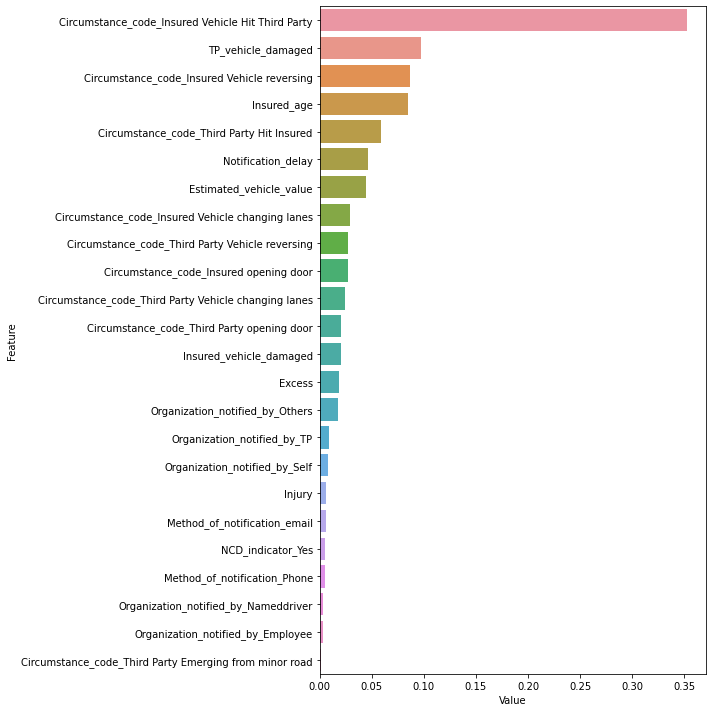

In [20]:
# Import seaborn and matplotlib.pyplot using the usual alias
import seaborn as sns
import matplotlib.pyplot as plt

# Code provided to increase the plot size for better legibility
plt.rcParams['figure.figsize'] = (10, 10)

# Create a DataFrame from a dictionary
feature_importances = pd.DataFrame({
    # Set the Feature column to the columns of dummies
    'Feature':dummies.columns,
    # Set the Value column to the feature importances of the best model
    'Value':best_rf.feature_importances_
})

# Sort feature_importances by the Value column
feature_importances_sorted = feature_importances.sort_values('Value', ascending = False)

# Using feature_importances_sorted, draw a barplot of Feature vs. Value
ax = sns.barplot(data = feature_importances_sorted, x='Value',y='Feature')
plt.show()

## More explanations with Shap

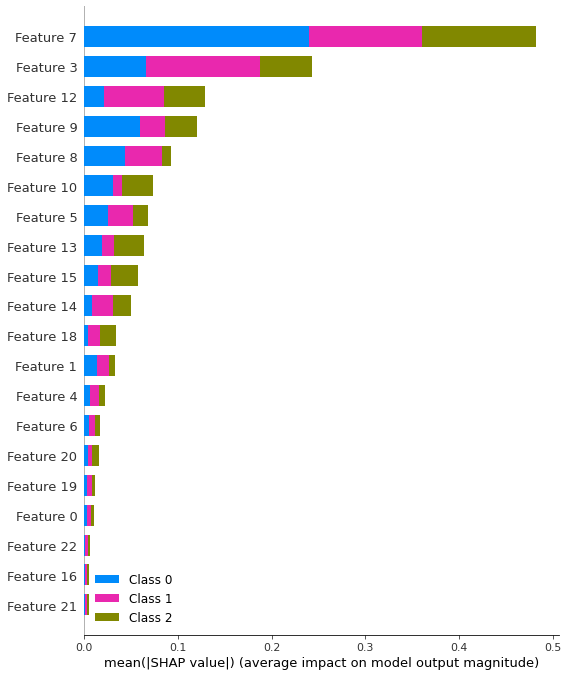

In [22]:
# Import TreeExplainer, and summary_plot from shap
import shap
from shap import TreeExplainer, summary_plot

# Create a tree explainer object from the best model
explainer = TreeExplainer(best_rf)

# Get the shap values from the testing features, without checking additivity
shap_values = explainer.shap_values(X_test)

# Draw a summary plot of the first shap value, with the testing features, getting class names from the best model
shap.summary_plot(shap_values)